In [1]:
# Импорт библиотек и общая настройка графиков
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(25,7)}
        )

In [2]:
# Считывание csv файлов и колонок с датами
olist_customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-durahov-21/start_project/olist_customers_dataset.csv')
olist_oders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-durahov-21/start_project/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 
                                                                   'order_delivered_carrier_date',
                                                                   'order_delivered_customer_date',
                                                                   'order_estimated_delivery_date'])
olist_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-durahov-21/start_project/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

In [3]:
# Объединение двух датафреймов для решения первой задачи. 
# В качестве покупки можно считать заказ со статусом delivered. Дата покупки - колонка order_estimated_delivery_date
buy_data = olist_oders \
    .query('order_status == "delivered"') \
    .merge(olist_customers, on='customer_id')

In [4]:
# Пользователи, совершившие покупку один раз и более одного раза.
users_count = buy_data.customer_unique_id \
    .value_counts() \
    .reset_index() \
    .rename(columns={'customer_unique_id': 'purchase_count', 'index': 'customer_unique_id'})
users_count['oneormore'] = np.where(users_count.purchase_count == 1, 'one', 'more_one')
users_count_plot = users_count \
    .groupby('oneormore', as_index=False) \
    .agg({'customer_unique_id': 'count'}) \
    .rename(columns={'customer_unique_id': 'customers_count'})
users_count_plot

,oneormore,customers_count
0,more_one,2801
1,one,90557


In [5]:
# Составление таблицы, показывающей среднее количество заказов в зависимости статуса заказа
olist_oders['month'] = olist_oders.order_estimated_delivery_date.dt.to_period('M')
canc_order = olist_oders \
    .groupby(['order_status', 'month'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .groupby('order_status', as_index=False) \
    .agg({'order_id': 'mean'}) \
    .rename(columns={'order_id': 'month_mean'}) \
    .sort_values('month_mean', ascending=False)
canc_order

,order_status,month_mean
3,delivered,3859.120000
6,shipped,48.130435
7,unavailable,29.000000
1,canceled,24.038462
5,processing,15.842105
4,invoiced,14.952381
2,created,1.666667
0,approved,1.000000


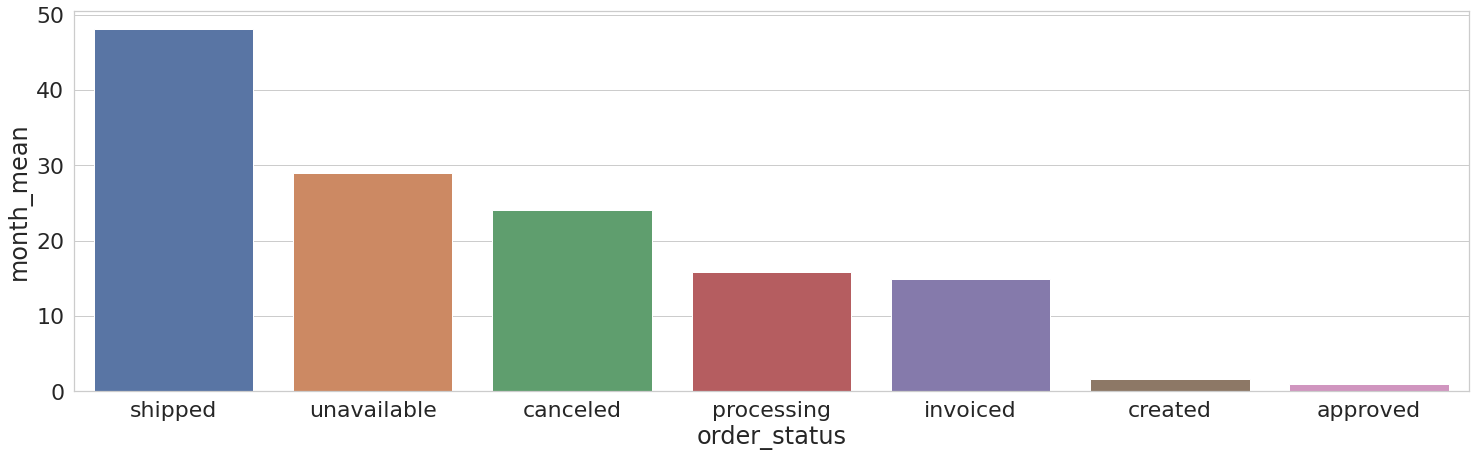

In [6]:
# Визуализация заказов, не доставленных по разным причинам.
sns.barplot(x='order_status', y='month_mean', data=canc_order.query('order_status != "delivered"'))

In [7]:
# Статусы approved, created, invoiced, processing, shipped показывают заказ в процессе. 
# их среднее значение невелико (по сравнению ссо статусом delivered). 
# Статус unavailable скорее всего указывает на остуствие товара в магазине.
# Статус canceled - отмененые заказы. Возможна, причина в долгой доставке товара. 
olist_oders['days_dost'] = olist_oders.order_estimated_delivery_date.dt.date-olist_oders.order_purchase_timestamp.dt.date
olist_oders \
    .query('order_status == "canceled"') \
    .days_dost.value_counts() \
    .reset_index() \
    .rename(columns={'index': 'days_canc', 'days_dost': 'order_count_canc'}) \
    .sort_values('order_count_canc', ascending=False).head()

,days_canc,order_count_canc
0,14 days,38
1,22 days,34
2,24 days,30
3,27 days,28
4,23 days,27


In [8]:
# Следующая таблица показывает самые частые сроки доставки, и они не меньше отмененных.
# Скорее всего, такое среднее количество отмененных заказов - стандартная ситуация в магазине, 
# учитывая их небольшую долю по сравнению с доставленными.
olist_oders \
    .days_dost.value_counts() \
    .reset_index() \
    .rename(columns={'index': 'days_dost', 'days_dost': 'order_count_dost'}) \
    .sort_values('order_count_dost', ascending=False).head()

,days_dost,order_count_dost
0,22 days,5988
1,23 days,5599
2,24 days,5513
3,25 days,5237
4,26 days,4859


In [10]:
# Объединяем третий датафрейм с уже ранее объединенными двумя датафреймами.
all_data = buy_data.merge(olist_items, how='left', on='order_id')

In [11]:
# Для каждого товара определяется день неделин с соответствущим количеством покупок
all_data['day_name'] = all_data.order_estimated_delivery_date.dt.day_name()
data_day_name = all_data \
    .groupby(['product_id', 'day_name'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .sort_values(['product_id', 'order_id'], ascending=False) \
    .rename(columns={'order_id': 'count_orders'})
data_day_name.head()

,product_id,day_name,count_orders
55279,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
55276,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,2
55277,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
55278,fffdb2d0ec8d6a61f0a0a0db3f25b441,Wednesday,1
55275,fff9553ac224cec9d15d49f5a263411f,Monday,1


In [12]:
# Определяем для каждого товара список дней с количеством покупок 
data_day_name['weekday'] = data_day_name.count_orders.astype('str')+' '+data_day_name.day_name
data_weekday = data_day_name \
    .groupby('product_id') \
    .weekday.apply(list).reset_index() 
data_weekday.head(10)

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,[1 Wednesday]
1,00088930e925c41fd95ebfe695fd2655,[1 Friday]
2,0009406fd7479715e4bef61dd91f2462,[1 Tuesday]
3,000b8f95fcb9e0096488278317764d19,"[1 Friday, 1 Monday]"
4,000d9be29b5207b54e86aa1b1ac54872,[1 Monday]
5,0011c512eb256aa0dbbb544d8dffcf6e,[1 Friday]
6,00126f27c813603687e6ce486d909d01,"[1 Monday, 1 Wednesday]"
7,001795ec6f1b187d37335e1c4704762e,"[3 Monday, 3 Thursday, 2 Tuesday, 1 Friday]"
8,001b237c0e9bb435f2e54071129237e9,[1 Tuesday]
9,001b72dfd63e9833e8c02742adf472e3,"[4 Friday, 4 Tuesday, 3 Monday, 1 Thursday, 1 ..."


In [13]:
# Создание функции для обработки списка для выявления дней недели, в который чаще всего покупается товар
def max_weekday(lst):
    x=[lst[0].split()[1]]
    for i in range(1,len(lst)):
        if len(lst)==1 or int(lst[i].split()[0])<int(lst[i-1].split()[0]):
            break
        if int(lst[i].split()[0])==int(lst[i-1].split()[0]):
            x+= [lst[i].split()[1]]
    return x


data_weekday.weekday = data_weekday.weekday.apply(max_weekday)
data_weekday.head(10)

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,[Wednesday]
1,00088930e925c41fd95ebfe695fd2655,[Friday]
2,0009406fd7479715e4bef61dd91f2462,[Tuesday]
3,000b8f95fcb9e0096488278317764d19,"[Friday, Monday]"
4,000d9be29b5207b54e86aa1b1ac54872,[Monday]
5,0011c512eb256aa0dbbb544d8dffcf6e,[Friday]
6,00126f27c813603687e6ce486d909d01,"[Monday, Wednesday]"
7,001795ec6f1b187d37335e1c4704762e,"[Monday, Thursday]"
8,001b237c0e9bb435f2e54071129237e9,[Tuesday]
9,001b72dfd63e9833e8c02742adf472e3,"[Friday, Tuesday]"


In [14]:
# Определние у каждого из пользователей в среднем покупок в неделю (по месяцам)
all_data['month'] = all_data.order_estimated_delivery_date.dt.to_period('M')
all_data['month_days'] = all_data.order_estimated_delivery_date.dt.daysinmonth
users_mean_week = all_data \
    .groupby(['customer_unique_id', 'month', 'month_days'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders_count'})
users_mean_week['mean_week'] = users_mean_week.orders_count*7/users_mean_week.month_days
users_mean_week = users_mean_week \
                        .drop(columns=['month_days', 'orders_count']) \
                        .sort_values('mean_week', ascending=False)
users_mean_week.head()

,customer_unique_id,month,mean_week
25822,4546caea018ad8c692964e3382debd19,2017-07,4.741935
39368,698e1cf81d01a3d389d96145f7fa6df8,2017-09,4.666667
73057,c402f431464c72e27330a67f7b94d4fb,2018-03,4.516129
74645,c8460e4251689ba205045f3ea17884a1,2018-08,4.064516
5742,0f5ac8d5c31de21d2f25e24be15bbffb,2017-12,4.064516


In [15]:
# Определние когорт пользователей для когортного анализа в период с января по декабрь 2017 года. 
# Когорты составляются по месяцу первой активности пользователя.
# В данном случае используется время создания заказа (order_purchase_timestamp)
from operator import attrgetter

kog_users = all_data \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': 'min'}) \
    .rename(columns={'order_purchase_timestamp': 'first_purchase_date'})
kog_users.first_purchase_date = kog_users.first_purchase_date.dt.to_period('M')
all_data = all_data.merge(kog_users, on='customer_unique_id')
all_data['month_orders'] = all_data.order_purchase_timestamp.dt.to_period('M')
df_cohort = all_data \
            .query('first_purchase_date > "2016-12" and first_purchase_date < "2018-01"') \
            .groupby(['first_purchase_date', 'month_orders']) \
            .agg(n_customers=('customer_unique_id', 'nunique')) \
            .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.month_orders - df_cohort.first_purchase_date).apply(attrgetter('n'))

In [16]:
# Сотавление таблицы коэффицентов удержания клиентов (retention) по когортам пользователей.
cohort_pivot = df_cohort.pivot_table(index = 'first_purchase_date',
                                     columns = 'period_number',
                                     values = 'n_customers') \
                        .rename(columns={i: 'm_'+ str(i) for i in range(20)}) 

for i in range(1,18):
    cohort_pivot['m_'+str(i)] = cohort_pivot['m_'+str(i)]*100/cohort_pivot.m_0
cohort_pivot['m_19'] = cohort_pivot['m_19']*100/cohort_pivot.m_0
cohort_pivot

period_number,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,m_13,m_14,m_15,m_16,m_17,m_19
first_purchase_date,,,,,,,,,,,,,,,,,,,
2017-01,717.0,0.278940,0.278940,0.139470,0.418410,0.139470,0.418410,0.139470,0.139470,NaN,0.418410,0.139470,0.697350,0.418410,0.139470,0.139470,0.278940,0.418410,0.13947
2017-02,1628.0,0.184275,0.307125,0.122850,0.429975,0.122850,0.245700,0.184275,0.122850,0.184275,0.122850,0.307125,0.122850,0.184275,0.122850,0.061425,0.061425,0.184275,NaN
2017-03,2503.0,0.439473,0.359569,0.399521,0.359569,0.159808,0.159808,0.319616,0.319616,0.079904,0.359569,0.119856,0.199760,0.119856,0.159808,0.239712,0.079904,0.119856,NaN
2017-04,2256.0,0.620567,0.221631,0.177305,0.265957,0.265957,0.354610,0.310284,0.310284,0.177305,0.265957,0.088652,0.044326,0.044326,0.088652,0.088652,0.132979,NaN,NaN
2017-05,3451.0,0.463634,0.463634,0.289771,0.289771,0.318748,0.405680,0.144886,0.260794,0.260794,0.260794,0.347725,0.231817,0.028977,0.173863,0.202840,NaN,NaN,NaN
2017-06,3037.0,0.493908,0.395127,0.428054,0.296345,0.395127,0.362200,0.230491,0.131709,0.197563,0.296345,0.362200,0.164636,0.164636,0.230491,NaN,NaN,NaN,NaN
2017-07,3752.0,0.533049,0.346482,0.239872,0.293177,0.213220,0.319829,0.106610,0.186567,0.266525,0.213220,0.293177,0.133262,0.239872,NaN,NaN,NaN,NaN,NaN
2017-08,4057.0,0.690165,0.345083,0.271136,0.345083,0.517624,0.295785,0.271136,0.147893,0.147893,0.246488,0.197190,0.123244,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4004.0,0.699301,0.549451,0.274725,0.449550,0.224775,0.224775,0.249750,0.274725,0.174825,0.249750,0.074925,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Максимальный retention на 3-й месяц наблюдается у когорты июня.
cohort_pivot.m_3.idxmax()

Period('2017-06', 'M')

In [18]:
# RFM-сегментация пользователей. 
# Границы метрики recency вычисляется по квантилям, где 1 - давняя покупка, 4 - самые свежие покупки.
# Границы метрики monetary также вычисляется по квантилям, где 1 - самые небольшие суммы, 4 - самые большие суммы покупок.
# Границы метрики frequency определялся по следующему принципу. 1 - один заказ (наибольшая часть (90557) всех ползователей - 97%),
# 2 - два заказа (2573 пользователя)б 3 - три заказа (181 пользователей), 4 - больше 3 заказов8 (228 пользователей)
import datetime
max_date = all_data.order_estimated_delivery_date.dt.date.max() + datetime.timedelta(days=1)
rec_freq_mon = all_data \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_estimated_delivery_date': 'max', 'price': 'sum', 'order_id': 'nunique'}) \
    .rename(columns={'order_estimated_delivery_date': 'last_purchase_date', 'price': 'revenue_month', 'order_id': 'order_count'})
rec_freq_mon['recency_days'] = max_date - rec_freq_mon.last_purchase_date.dt.date
intervals_rec = [rec_freq_mon.recency_days.min()] + list(rec_freq_mon.recency_days.quantile(q=[0.25, 0.5, 0.75])) + [rec_freq_mon.recency_days.max()]
intervals_mon = [rec_freq_mon.revenue_month.min()] + list(rec_freq_mon.revenue_month.quantile(q=[0.25, 0.5, 0.75])) + [rec_freq_mon.revenue_month.max()]
rec_freq_mon['rec_number'] = pd.cut(rec_freq_mon.recency_days, intervals_rec, labels=['4','3','2','1'])
rec_freq_mon['mon_number'] = pd.cut(rec_freq_mon.revenue_month, intervals_mon, labels=['1','2','3','4'])
rec_freq_mon['freq_number'] = pd.cut(rec_freq_mon.order_count, [0,1,2,3,15], labels=['1','2','3','4'])
rec_freq_mon['rfm'] = rec_freq_mon.rec_number.astype('str') + rec_freq_mon.freq_number.astype('str') + rec_freq_mon.mon_number.astype('str')
rec_freq_mon.head()

,customer_unique_id,last_purchase_date,revenue_month,order_count,recency_days,rec_number,mon_number,freq_number,rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-21,129.90,1,158 days,3,3,1,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-15,18.90,1,164 days,3,1,1,311
2,0000f46a3911fa3c0805444483337064,2017-04-07,69.00,1,567 days,1,2,1,112
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11-13,25.99,1,347 days,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,2017-12-05,180.00,1,325 days,2,4,1,214


In [19]:
# Таблица границ сегментов
intervals = pd.concat([rec_freq_mon.recency_days.quantile(q=[0.25, 0.5, 0.75]), 
                       pd.DataFrame(['1 order','2 orders','3 orders'], index=[0.25,0.50,0.75], columns=['order_count']),
                       rec_freq_mon.revenue_month.quantile(q=[0.25, 0.5, 0.75])], axis=1) \
            .reset_index(drop=True) \
            .rename(index={0: '1-2', 1: '2-3', 2: '3-4'})
intervals

,recency_days,order_count,revenue_month
1-2,150 days,1 order,47.6500
2-3,249 days,2 orders,89.7300
3-4,381 days,3 orders,154.7375


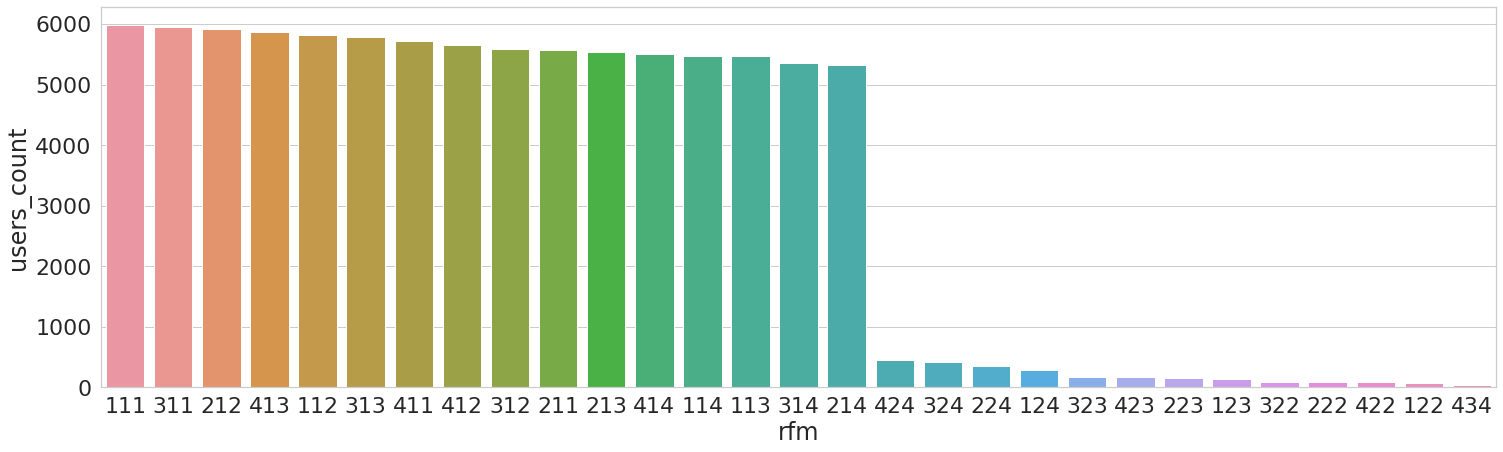

In [20]:
# Визуализация количества пользователей с разным сочетанием метрик. 
plot_rfm = rec_freq_mon \
    .groupby('rfm', as_index=False) \
    .agg({'customer_unique_id': 'count'}) \
    .rename(columns={'customer_unique_id': 'users_count'}) \
    .query('users_count > 40') \
    .sort_values('users_count', ascending=False)
sns.barplot(x='rfm', y='users_count', data=plot_rfm)